In [86]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pickle

In [87]:
df = pd.read_csv('ads dataset.csv')
df = df.iloc[0:600]
df

,Age,Male,Income,Area,Extrovert,Weekday,Time,Ad location,Ad variant,Clicked
0,18,1,13279,Rural,1,1,Evening,Push notif,Sports,1
1,20,1,14428,Rural,1,1,Evening,Push notif,Sports,1
2,21,1,16785,Rural,1,1,Evening,Push notif,Sports,1
3,19,1,14912,Rural,1,1,Evening,Push notif,Sports,1
4,18,1,13183,Rural,1,1,Evening,Push notif,Sports,1
...,...,...,...,...,...,...,...,...,...,...
595,36,1,59296,Suburban,0,0,Midnight,Push notif,Finance,1
596,49,1,45055,Rural,0,1,Midnight,Banner,Finance,1
597,44,1,57379,Suburban,0,0,Midnight,Banner,Finance,1
598,42,0,53132,Rural,0,1,Midnight,Push notif,Finance,1


In [88]:
df = df.drop('Clicked', axis=1) # get only clicked rows

X = df.drop(['Ad variant', 'Ad location'], axis=1)
y = df[['Ad location', 'Ad variant',]]
X = pd.get_dummies(X, dtype='int')

In [89]:
X

,Age,Male,Income,Extrovert,Weekday,Area_Rural,Area_Suburban,Area_Urban,Time_Afternoon,Time_Evening,Time_Midnight,Time_Morning
0,18,1,13279,1,1,1,0,0,0,1,0,0
1,20,1,14428,1,1,1,0,0,0,1,0,0
2,21,1,16785,1,1,1,0,0,0,1,0,0
3,19,1,14912,1,1,1,0,0,0,1,0,0
4,18,1,13183,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,36,1,59296,0,0,0,1,0,0,0,1,0
596,49,1,45055,0,1,1,0,0,0,0,1,0
597,44,1,57379,0,0,0,1,0,0,0,1,0
598,42,0,53132,0,1,1,0,0,0,0,1,0


In [90]:
y

,Ad location,Ad variant
0,Push notif,Sports
1,Push notif,Sports
2,Push notif,Sports
3,Push notif,Sports
4,Push notif,Sports
...,...,...
595,Push notif,Finance
596,Banner,Finance
597,Banner,Finance
598,Push notif,Finance


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape

((420, 12), (420, 2))

In [83]:
X_day = []
y_day = []
mult = 42 # data per day
for i in range(10): # 10 days
    X_day.append(X_train.iloc[i*mult:(i+1)*mult])
    y_day.append(y_train.iloc[i*mult:(i+1)*mult])

mnb = MultinomialNB()
model = MultiOutputClassifier(mnb)
model.fit(X_day[0], y_day[0]) # day 0

ctr = []
df_pred = pd.DataFrame(model.predict(X_day[0]), columns=['Ad location_pred', 'Ad variant_pred'])
df_pred[['Ad location', 'Ad variant']] = y_day[0].to_numpy()
df_pred['Equal'] = (df_pred['Ad location_pred'] == df_pred['Ad location']) & (df_pred['Ad variant_pred'] == df_pred['Ad variant'])
ctr.append(sum(df_pred['Equal'] == True)/len(df_pred.index))
print('Day 0 CTR: ', sum(df_pred['Equal'] == True)/len(df_pred.index))

Day 0 CTR:  0.9047619047619048


In [84]:
for i in range(1,9):
    model.partial_fit(X_day[i], y_day[i]) # day 1 onwards
    df_pred = pd.DataFrame(model.predict(X_day[i+1]), columns=['Ad location_pred', 'Ad variant_pred'])
    df_pred[['Ad location', 'Ad variant']] = y_day[i+1].to_numpy()
    df_pred['Equal'] = (df_pred['Ad location_pred'] == df_pred['Ad location']) & (df_pred['Ad variant_pred'] == df_pred['Ad variant'])
    ctr.append(sum(df_pred['Equal'] == True)/len(df_pred.index))
    print('Day '+str(i)+' CTR: ', sum(df_pred['Equal'] == True)/len(df_pred.index))

Day 1 CTR:  0.8333333333333334
Day 2 CTR:  0.8333333333333334
Day 3 CTR:  0.8333333333333334
Day 4 CTR:  0.8809523809523809
Day 5 CTR:  0.9047619047619048
Day 6 CTR:  0.8571428571428571
Day 7 CTR:  0.9047619047619048
Day 8 CTR:  0.8809523809523809


<Axes: >

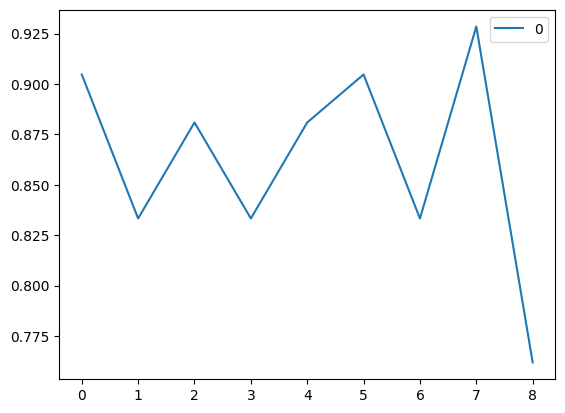

In [23]:
pd.DataFrame(ctr).plot()

In [55]:
pickle.dump(model, open('recommender.pkl', 'wb'))